In [4]:
%load_ext autoreload
%autoreload 2
import sys
import platform
from pathlib import Path
from os import environ
if platform.system() == "Darwin": # Nat laptop
    sys.path.extend(['/Users/nkinsky/Documents/UM/GitHub/NeuroPy'])
    sys.path.extend(['/Users/nkinsky/Documents/UM/GitHub/Projects_sandbox'])
else:
    if environ["HOSTNAME"] == "lnx00004": # Nat Linux computer
        sys.path.extend(['/data/GitHub/NeuroPy'])
        sys.path.extend(['/data/GitHub/Projects_sandbox'])
    
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import scipy.signal as sg
import matplotlib.pyplot as plt
from neuropy.utils.mathutil import min_max_scaler
from scipy.ndimage import gaussian_filter1d, gaussian_filter
from copy import deepcopy
from tqdm import tqdm

from neuropy import plotting
from neuropy.analyses.placefields import Pf1D, Pf1Dsplit
from neuropy.analyses.oscillations import detect_theta_epochs
from neuropy.core.position import Position
from neuropy.core.epoch import Epoch
from neuropy.plotting.ratemaps import plot_ratemap
from neuropy.plotting.figure import Fig
from neuropy.utils.misc import flatten
from neuropy.io import BinarysignalIO

from Psilocybin.subjects import get_psi_dir

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Specify plotting parameters

In [5]:
animals = ["Finn", "Rey", "Rose", "Finn2"]

In [70]:
ripple_thresh = 2.5 # 2.5 or 4

# Cut down Finn2 saline to 1hr?
chop_finn2_saline = False  # True = only use 1st hour of Finn2 saline, False = use all
finn2_append = "_1hrsalineonly" if chop_finn2_saline else ""

# ... OR only use 1hr Psilocybin for all
limit_to_1st_hr = True
chop_all_append = "_allsessions1hr" if limit_to_1st_hr else ""
finn2_append = "" if chop_all_append else finn2_append

## Load in data

In [73]:
df_grp = []
for animal in animals:
    file_use = get_psi_dir(animal, "Saline1").parent / "aggdata" / f"{animal.lower()}_rpl_features_thresh{'_'.join(str(ripple_thresh).split('.'))}{chop_all_append}.csv"
    df_animal = pd.read_csv(file_use, index_col=0)
    df_animal["Animal"] = animal
    df_grp.append(df_animal)

df_grp = pd.concat(df_grp, axis=0, ignore_index=True)
df_grp
    

,start,stop,peak_time,peak_power,duration,peak_frequency_bp,label,sharp_wave_amplitude,session,Animal
0,0.9184,0.9992,0.9712,8275.3125,0.0808,165.151515,NaN,13.609159,Saline 1,Finn
1,1.1328,1.1928,1.1664,11766.3070,0.0600,131.818182,NaN,6.622136,Saline 1,Finn
2,31.1544,31.2080,31.1832,8323.5530,0.0536,140.909091,NaN,13.090663,Saline 1,Finn
3,60.0312,60.0872,60.0600,8817.6870,0.0560,222.727273,NaN,8.519090,Saline 1,Finn
4,64.9136,65.0320,64.9408,11203.7460,0.1184,133.333333,NaN,10.264427,Saline 1,Finn
...,...,...,...,...,...,...,...,...,...,...
17649,3576.4264,3576.4920,3576.4624,20862.4240,0.0656,162.121212,NaN,4.036974,Saline 2,Finn2
17650,3578.8744,3578.9472,3578.9248,15843.5850,0.0728,127.272727,NaN,3.909696,Saline 2,Finn2
17651,3581.0040,3581.0640,3581.0376,13887.2980,0.0600,134.848485,NaN,5.013565,Saline 2,Finn2
17652,3581.7976,3581.9920,3581.8400,41372.5800,0.1944,131.818182,NaN,12.025231,Saline 2,Finn2


In [74]:
df_mean = df_grp.groupby(["Animal", "session"]).mean().reset_index()
df_mean["session"] = pd.Categorical(df_mean["session"], categories=["Saline 1", "Psilocybin", "Saline 2"])
df_mean

,Animal,session,start,stop,peak_time,peak_power,duration,peak_frequency_bp,label,sharp_wave_amplitude
0,Finn,Psilocybin,1434.586752,1434.700811,1434.645162,8882.801698,0.114059,138.513601,NaN,5.503128
1,Finn,Saline 1,1897.440834,1897.569530,1897.505992,10639.255695,0.128696,145.003129,NaN,5.629058
2,Finn,Saline 2,1049.526244,1049.625710,1049.577504,12377.208752,0.099466,140.781069,NaN,5.731728
3,Finn2,Psilocybin,1572.918861,1573.026491,1572.973126,23492.810445,0.107630,134.045708,NaN,5.154888
4,Finn2,Saline 1,1776.126822,1776.230334,1776.178194,21807.190640,0.103512,136.009703,NaN,4.911547
5,Finn2,Saline 2,1664.216549,1664.321178,1664.268798,26554.927315,0.104629,135.796853,NaN,6.012975
6,Rey,Psilocybin,1269.288178,1269.403630,1269.346346,8517.529252,0.115452,136.464560,NaN,7.200885
7,Rey,Saline 1,1260.822826,1260.916462,1260.869781,9215.319899,0.093635,135.776311,NaN,6.842761
8,Rey,Saline 2,1574.670067,1574.765265,1574.719616,9215.377653,0.095198,136.204147,NaN,7.232981
9,Rose,Psilocybin,1213.309603,1213.422259,1213.365446,98193.455977,0.112656,165.418802,NaN,4.620359


<Axes: xlabel='session', ylabel='duration'>

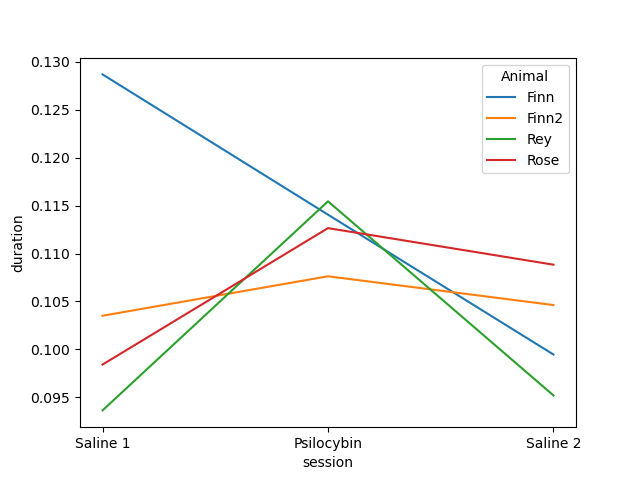

In [75]:
_, ax = plt.subplots()
sns.lineplot(data=df_mean, x="session", y="duration", hue="Animal", ax=ax)

FEATURE: duration
Saline 1 mean = 0.10623403168114559, Psilocybin mean = 0.11198344150148977
Mann-Whitney U test p-value=6.740216397814325e-19

Psilocybin mean = 0.11198344150148977, Saline 2 mean = 0.1026042749095702
Mann-Whitney U test p-value=6.274800269495214e-32

Saline 1 mean = 0.10623403168114559, Saline 2 mean = 0.1026042749095702
Mann-Whitney U test p-value=0.01643169102794533



FEATURE: peak_power
Saline 1 mean = 13724.19064256515, Psilocybin mean = 43118.52424225576
Mann-Whitney U test p-value=2.1293188500572046e-249

Psilocybin mean = 43118.52424225576, Saline 2 mean = 14163.471701200264
Mann-Whitney U test p-value=3.046895471590053e-254

Saline 1 mean = 13724.19064256515, Saline 2 mean = 14163.471701200264
Mann-Whitney U test p-value=0.9170833471515974



FEATURE: peak_frequency_bp
Saline 1 mean = 139.33019515543788, Psilocybin mean = 145.8215730360968
Mann-Whitney U test p-value=8.65559129836589e-20

Psilocybin mean = 145.8215730360968, Saline 2 mean = 140.1562484429962


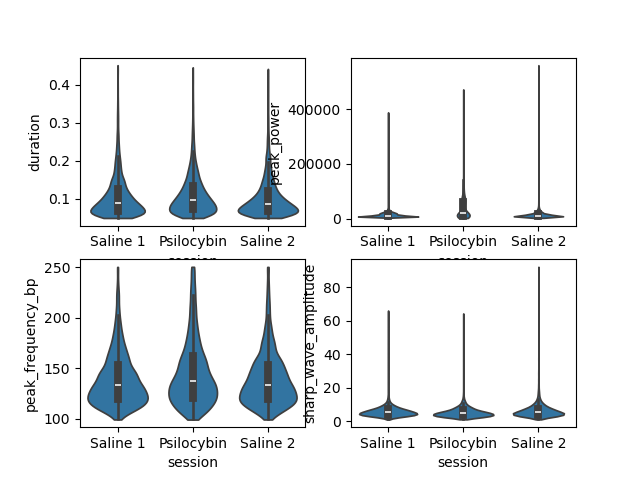

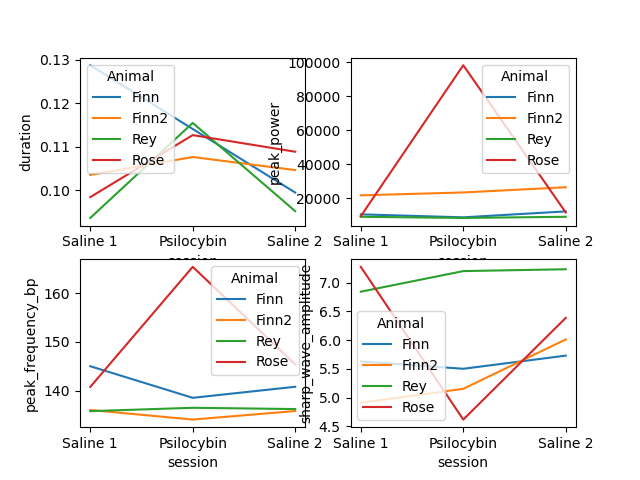

In [76]:
%matplotlib widget
features = ["duration", "peak_power", "peak_frequency_bp", "sharp_wave_amplitude"]
_, ax = plt.subplots(2, 2)
for feature, a in zip(features, ax.reshape(-1)):
    sns.violinplot(data=df_grp, x="session", y=feature, cut=0.1, ax=a)
    # sal1_df = df_grp[df_grp.session == "Saline 1"]
    # psi_df = df_grp[df_grp.session == "Psilocybin"]
    # sal2_df = df_grp[df_grp.session == "Saline 2"]

    # sal1_v_psi = stats.mannwhitneyu(sal1_df[feature].values, psi_df[feature].values)
    # psi_v_sal2 = stats.mannwhitneyu(psi_df[feature].values, sal2_df[feature].values)
    # sal1_v_sal2 = stats.mannwhitneyu(sal1_df[feature].values, sal2_df[feature].values)

    print(f"FEATURE: {feature}")
    for grps_use in [["Saline 1", "Psilocybin"], ["Psilocybin", "Saline 2"], ["Saline 1", "Saline 2"]]:
        grp1_vals = df_grp[df_grp.session == grps_use[0]][feature].values
        grp2_vals = df_grp[df_grp.session == grps_use[1]][feature].values
        print(f"{grps_use[0]} mean = {np.mean(grp1_vals)}, {grps_use[1]} mean = {np.mean(grp2_vals)}")
        mannu_stats = stats.mannwhitneyu(grp1_vals, grp2_vals)
        print(f"Mann-Whitney U test p-value={mannu_stats.pvalue}\n")
    print("\n")

_, ax = plt.subplots(2, 2)
for feature, a in zip(features, ax.reshape(-1)):
    sns.lineplot(data=df_mean, x="session", y=feature, hue="Animal", ax=a)